## Зубеня Дз 5

In [1]:
%matplotlib inline


Fine Tuning and Transfer Learning 
==============================================

В этом задании мы натренируем предобученную нейросеть с помощью tranfer learning для решения задачи классификации муравьев и пчел.

Тренировка нейросети со случайными начальными весами слоев требует большого количества данных и затрат времени на обучение.  
Поэтому на практике используют модели (архитектура + веса), которые обучались на больших стандартных датасетах.  

Для дообучения обычно используют два различных сценария:  
- **Finetuning** - дообучение параметров всех слоев нейросети. Параметры не случайны, а получены в ходе обучения модели на большом датасете, например ImageNet (1000 классов, миллионы изображений). Функции forward и backward вызываются для всех слоев. 
- **Feature extraction** - дообучаются только последние слои. Используются как правило линейные слои, их может быть один или несколько. Параметры предобученных слоев в процесее обучения не изменяются. В целом, работу предобученной части нейросети можно представить как извлечение некоторых абстрактрых признаков, на основании которых последние слои позволяют отнести входное изображение к тому или иному классу. Функции forward вызываются для всех слоев, а backward только для дообучаемых.

Итак, план действий таков:  

1. Импорт необходимых модулей
2. Загрузка, нормализация и аугментация данных
3. Определение процесса тренировки нейросети и визуализации результатов
4. Дообучение всех слоев нейросети, предобученных на большом датасете (Fine Tuning)
5. Обучение только последнего линейного слоя (Transfer Learning)

## 1. Импорт модулей

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 2. Загрузка данных

We will use torchvision and torch.utils.data packages for loading the
data.

Для загрузки данных воспользуемся готовыми инструментами из модуля `torchvision` и `torch.utils`:
- `datasets.ImageFolder` - создает датасет из изображений, разложенных по папкам `train` и `val`
- `data.DataLoader` - итератор по датасету
- `transforms.Compose` - цепочка предобработки данных


The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

Датасет с изображениями пчел и муравьев представляет собой очень малую подвыборку `ImageNet`
Изображения имеют разный размер, около  400 на 400 пикселей RGB.
На каждый класс приходится около 120 обучающих изображений и 70 тестовых.

Данные доступны по ссылке
   `<https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_

In [4]:
# TODO загрузите данные и распакуйте в текущую папку
! wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
! unzip hymenoptera_data.zip

--2021-06-15 09:12:45--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.221.55, 13.224.221.6, 13.224.221.14, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.221.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   119MB/s    in 0.4s    

2021-06-15 09:12:46 (119 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/

In [5]:
# TODO добавьте preprocessing and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(220),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(220),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Визуализируем несколько изображений c помощью TensorBoard, посмотрим на что они стали похожи после аугментаций.

In [6]:
# TODO визуализация изображений с помощью tensorboard
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs')
%load_ext tensorboard

In [7]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images, normalize=True)
writer.add_image('Train images', img_grid)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 3. Определение процесса тренировки нейросети

Напишите функцию тренировки нейросети, в которой реализованы следующие возможности:

- снижение learning rate
- сохранение модели с лучшими результатами
- использование одной функции как для фазы тренировки, так и валидации
- запись loss, train val accuracy в tensorboard

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # TODO Set model to training mode
                model.train()
            else:
                # TODO Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # TODO move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # TODO zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # TODO backward + optimize only if in training phase

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            # TODO calculate loss and accuracy and write to tensorboard
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Функция для визуализации предсказаний модели

In [10]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = [0.229, 0.224, 0.225] * inp + [0.485, 0.456, 0.406]
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 4. Finetuning всех весов

In [12]:
# TODO use pretrained model
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to num_classes.
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.5 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

На CPU процесс обучения занимает несколько минут.

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7018 Acc: 0.5779
val Loss: 0.6463 Acc: 0.6405

Epoch 1/9
----------
train Loss: 0.7054 Acc: 0.4877
val Loss: 0.6453 Acc: 0.5817

Epoch 2/9
----------
train Loss: 0.6648 Acc: 0.5697
val Loss: 0.6669 Acc: 0.6013

Epoch 3/9
----------
train Loss: 0.6290 Acc: 0.6680
val Loss: 0.6377 Acc: 0.6144

Epoch 4/9
----------
train Loss: 0.6344 Acc: 0.6230
val Loss: 0.6375 Acc: 0.5882

Epoch 5/9
----------
train Loss: 0.6264 Acc: 0.6393
val Loss: 0.6329 Acc: 0.6601

Epoch 6/9
----------
train Loss: 0.6191 Acc: 0.6516
val Loss: 0.6539 Acc: 0.5948

Epoch 7/9
----------
train Loss: 0.6122 Acc: 0.6803
val Loss: 0.6531 Acc: 0.6340

Epoch 8/9
----------
train Loss: 0.6183 Acc: 0.6721
val Loss: 0.6692 Acc: 0.6209

Epoch 9/9
----------
train Loss: 0.6103 Acc: 0.6721
val Loss: 0.6460 Acc: 0.6340

Training complete in 0m 57s
Best val Acc: 0.660131


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


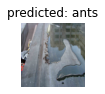

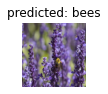

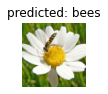

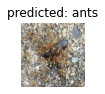

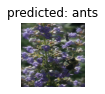

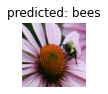

In [14]:
visualize_model(model_ft)

## 5. Trainsfer Learning (Feature extractor)

Теперь заморозим веса всех слоев модели, за исключением последнего. Для этого нужно установить параметр `requires_grad == False` для каждого слоя. Функция `backward` этих слоев не будет вызываться в процессе обучения, что весьма ускорит процесс.  

Более подробно `<https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


На CPU  обучение должно пройти примерно в два раза быстрее. 
Не забываем, что функция `forward` вычисляется по прежнему для всех слоев.

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6950 Acc: 0.6516
val Loss: 0.3378 Acc: 0.8366

Epoch 1/9
----------
train Loss: 0.4348 Acc: 0.8033
val Loss: 0.2271 Acc: 0.9216

Epoch 2/9
----------
train Loss: 0.3693 Acc: 0.8402
val Loss: 0.1608 Acc: 0.9412

Epoch 3/9
----------
train Loss: 0.3012 Acc: 0.8484
val Loss: 0.1590 Acc: 0.9412

Epoch 4/9
----------
train Loss: 0.4379 Acc: 0.8156
val Loss: 0.1979 Acc: 0.9281

Epoch 5/9
----------
train Loss: 0.4663 Acc: 0.8033
val Loss: 0.1622 Acc: 0.9412

Epoch 6/9
----------
train Loss: 0.5833 Acc: 0.7623
val Loss: 0.1588 Acc: 0.9477

Epoch 7/9
----------
train Loss: 0.3565 Acc: 0.8320
val Loss: 0.1563 Acc: 0.9477

Epoch 8/9
----------
train Loss: 0.3429 Acc: 0.8607
val Loss: 0.1432 Acc: 0.9542

Epoch 9/9
----------
train Loss: 0.2671 Acc: 0.8975
val Loss: 0.1502 Acc: 0.9477

Training complete in 0m 40s
Best val Acc: 0.954248


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


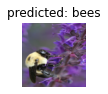

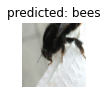

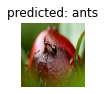

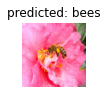

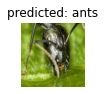

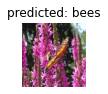

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()